### Q&A

---
#### **For which of the models already studied is the curse of dimensionality relevant and explain why.**

The **curse of dimensionality** is relevant to several models, espesically those sensitive to **distance, sparsity, or overfitting**.

1. **k-Nearest Neighbors (k-NN) - Highly affected**

k-NN relies on distance calculations between points.
In high dimensions, all points tend to be similarly distant from each other (distance metrics become less meaningful), making it hard to find "nearest" neighbors. This results in poor performance and unreliable predictions.

2. **Decision Trees and Ensembles (Random Forests, GBDT) - Moderately affected**

Tree split the feature space, and in high dimensions, the number of possible splits grows exponentially. This can lead to overfitting and very deep trees because data becomes sparse in high-dimensional space. The result is increased model complexity and variance.

3. **Support Vector Machines (SVM) – Affected, especially with RBF kernel**

SVM tries to find a separating hyperplane, and in high dimensions, data becomes harder to separate linearly without overfitting. Kernels like RBF become less effective when distances lose meaning in high dimensions. Needs more regularization and feature selection.

4. **Linear Models (Logistic Regression, Linear Regression) – Mildly affected**

They don't rely on distances but still suffer when the number of features is much larger than the number of samples.Risk of overfitting and instability in parameter estimation. Requires regularization (like L1/L2) or dimensionality reduction (PCA).

5. **Clustering Algorithms (e.g., k-Means) – Highly affected**

Like k-NN, k-Means depends on distances. In high dimensions, all distances converge, and cluster centers become less meaningful. It results in poor clustering performance.

---
#### **What is the difference between PCA and SVD?**

**PCA**

Goal: Dimensionality reduction while retaining as much variance as possible.

Use cases: Feature extraction, data compression, noise reduction, visualization.

Input requirements: Requires **mean-centered data**. Otherwise, the first component might just capture the mean.

Output interpretation:
- Eigenvectors $→$ directions of maximum variance.
- Eigenvalues $→$ variance explained by each component.

PCA gives principal axes (directions) and the variance captured by each.

**SVD**

Goal: Matrix factorization into three matrices for general-purpose linear algebra

Use cases: Solving linear systems, computing pseudoinverse, PCA implementation, low-rank approximations.

Input requirements: Work on **any matrix**, centered or not.

Output interpretation:

- Left singular vectors → projections in row space.

- Right singular vectors → directions in column space.

- Singular values → scale of the transformation.

SVD gives left/right singular vectors and scaling factors (singular values).

---

#### **What is the difference between NMF and SVD?**

Both NMF and SVD are matrix factorization techniques used to approximate a matrix by breaking it into simpler, lower-dimensional parts — often for tasks like dimensionality reduction, topic modeling, or recommendation systems.

**SVD**

- Break a matrix into **3 parts**: $ X = UΣVᵀ $
- Can have **negative and positive values**
- Used for: PCA, image compression, noise reduction.
- Harder to interpret because of **mixed signs**.
- Works on **any matrix**, even with negative values.

**NMF**

- Breaks a matrix into **2 parts**: $ X ≈ WH $
- Only uses **non-negative values** (no negatives).
- Used for: Topic modelling, recommender systems.
- Easier to interpret - parts "add up" to make the whole.
- Only works if the input data has **no negative numbers**.

Main difference:
- **SVD** uses **positive and negative values** and finds the best mathematical fit. It captures directions of greatest variance (like PCA) and uses both positive and negative combinations.

- **NMF** only uses **positive values** and gives more **interpreatable** results. It enforces a **parts-based representation**, where components add up to approximate the original - which makes it useful when negative values don't make sense (e.g., pixels, word counts).

---

#### **Describe the structure of the Locally Linear Embedding dimension reduction algorithm.**

LLE aims to reduce high-dimensional data to a lower-dimensional space **while preserving local relationships** between nearby data points.

Each data point can be reconstructed from a **linear combination of its nearest neighbors**. LLE finds a low-dimensional representation where these same combinations still reconstruct the data.s

**Steps of LLE:**

1. **Find nearest neighbors**

For each point, find its **k nearest neighbors (the closest points)**. This defines the **local neighborhood** for each point.

2. **Compute reconstruction weights**

Figure out how to write each point as a **combination of its neighbors (using weights). These weights show how each point depends on its neighbors.

3. **Map to low dimensions**

Find new low-dimensional points that **keep the same weights** between neighbors. So, if a point was built from 3 neighbors before, it still is - just in fewer dimensions.

**Key Characteristics:**
- **Nonlinear** method - captures curved manifolds better than PCA.
- **Manifold learning** - assumes data lies on a lower-dimensional manifold.
- **No global distances preserved**, only **local geometry**.
- Needs parameter: number of neighbors **k**.

---

### Imports

In [ ]:
%pip install category_encoders

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import CountEncoder

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import time

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from umap import UMAP

import warnings

### Classification with Sparse Features

In [16]:
import kagglehub

path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")

ratings_df = pd.read_csv(path + '/Ratings.csv')
users_df = pd.read_csv(path + '/Users.csv')

ratings_df.to_csv('Ratings.csv', index=False)
users_df.to_csv('Users.csv', index=False)

100%|██████████| 24.3M/24.3M [00:02<00:00, 11.6MB/s]

Extracting files...


In [3]:
ratings_df = pd.read_csv('./drive/MyDrive/data/ML_6/Ratings.csv')
users_df = pd.read_csv('./drive/MyDrive/data/ML_6/Users.csv')

df = ratings_df.merge(users_df, on='User-ID')

Missing values

In [5]:
# print(df.isna().sum())
# print((df[df.columns] == 0).sum())
# print((df[(df['Age'] <= 5) | (df['Age'] >= 100)]).shape[0])

Around 310,000 rows have missing age values (Age = NaN)

Around 716,000 rows have Book-Rating == 0 (indicating no rating)

Around 5,440 rows contain unrealistic age values (≤5 or ≥100)

In [6]:
df = df[df['Book-Rating'] > 0]
df = df[(df['Age'] >= 5) & (df['Age'] <= 100)]

In [7]:
# df.isna().sum()
# df.info()
# df

Sparse User-Book Interaction Matrix

In [9]:
df['user_idx'] = df['User-ID'].astype('category').cat.codes
df['book_idx'] = df['ISBN'].astype('category').cat.codes

In [10]:
# df

In [11]:
ratings = df['Book-Rating'].values
users = df['user_idx'].values
books = df['book_idx'].values

In [278]:
# print(len(ratings))
# print(len(np.unique(users)))
# print(len(np.unique(books)))

# books
# users
# ratings

In [13]:
interaction_matrix = csr_matrix(
    (ratings, (users, books)),
    shape=(df['user_idx'].nunique(), df['book_idx'].nunique())
)

In [14]:
# pd.DataFrame(interaction_matrix.toarray())

In [15]:
interaction_matrix.toarray().shape

(46365, 146361)

In [16]:
y = df.groupby('user_idx')['Age'].first().sort_index().values

Splitting Data

In [17]:
num_users = len(y)

train_idx, temp_idx = train_test_split(np.arange(num_users), test_size=0.3, random_state=42)
valid_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

X_train = interaction_matrix[train_idx]
X_valid = interaction_matrix[valid_idx]
X_test = interaction_matrix[test_idx]

y_train = y[train_idx]
y_valid = y[valid_idx]
y_test = y[test_idx]

print(f'Train size: {len(train_idx)}, Valid size: {len(valid_idx)}, Test size: {len(test_idx)}')

Train size: 32455, Valid size: 6955, Test size: 6955


Training linear and random forest models to predict user age based on user-books interactions.

In [45]:
start = time.time()

param_grid = {'alpha': [0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train)

print("Best alpha:", grid_ridge.best_params_['alpha'])
print("Validation RMSE:", (-grid_ridge.best_score_)**0.5)
print(f"Time: {time.time() - start:.2f} seconds")

Best alpha: 100
Validation RMSE: 14.938955704109674
Time: 29.43 seconds


In [40]:
start = time.time()

rf = RandomForestRegressor(n_estimators=10, max_depth=7, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)
print("Validation RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print(f"Time: {time.time() - start:.2f} seconds")

Validation RMSE: 13.774304261394025
Time: 50.15 seconds


In [44]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_valid)

print("Dummy RMSE:", np.sqrt(mean_squared_error(y_valid, y_dummy)))

Dummy RMSE: 13.786338260772803


---

Using PCA and UMAP to reduce the dimensionality of the features.


In [34]:
start = time.time()

svd = TruncatedSVD(n_components=50, random_state=42)
X_train_pca = svd.fit_transform(X_train)
X_valid_pca = svd.transform(X_valid)
X_test_pca = svd.transform(X_test)

print(f'Time: {time.time() - start:.2f} seconds')

Time: 11.38 seconds


In [21]:
warnings.filterwarnings("ignore")

start = time.time()

umap_model = UMAP(n_components=20, n_jobs=-1)
X_train_umap = umap_model.fit_transform(X_train_pca)
X_valid_umap = umap_model.transform(X_valid_pca)
X_test_umap = umap_model.transform(X_test_pca)

print(f'Time: {time.time() - start:.2f} seconds')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Time: 156.74 seconds


In [30]:
X_train_umap.shape

(32455, 20)

Training after Dimensionality reduction

In [35]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid, label=""):
  start = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_valid)
  rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
  print(f"{label} RMSE: {rmse:.4f} | Time: {time.time() - start:.2f} sec")

In [36]:
evaluate_model(Ridge(alpha=100), X_train_pca, y_train, X_valid_pca, y_valid, "Ridge (PCA)")
evaluate_model(Ridge(alpha=100), X_train_umap, y_train, X_valid_umap, y_valid, "Ridge (UMAP)")
evaluate_model(RandomForestRegressor(n_estimators=10, max_depth=7, n_jobs=-1, random_state=42),
               X_train_pca, y_train, X_valid_pca, y_valid, "RF (PCA)")
evaluate_model(RandomForestRegressor(n_estimators=10, max_depth=7, n_jobs=-1, random_state=42),
               X_train_umap, y_train, X_valid_umap, y_valid, "RF (UMAP)")

Ridge (PCA) RMSE: 13.7499 | Time: 0.02 sec
Ridge (UMAP) RMSE: 13.7487 | Time: 0.01 sec
RF (PCA) RMSE: 13.5218 | Time: 10.54 sec
RF (UMAP) RMSE: 13.6191 | Time: 3.71 sec


**Ridge Regression**

- On original features, Ridge underperforms with RMSE ≈ 14.94.

- Applying  PCA or UMAP reduces RMSE to around 13.75, and drastically reduces training time.

- This shows that linear models benefit greatly from dimensionality reduction.



**Random Forest**

- Performs better than Ridge on all feature sets.

- Achieves the best RMSE of 13.52 using PCA-compressed features.

- Training time reduces significantly with PCA or UMAP (from ~50s to ~10s), while maintaining or improving accuracy.

- Although RF can handle high-dimensional sparse data, it still benefits from dimensionality reduction.

### Visualizations

In [206]:
from sklearn.datasets import load_digits

digits = load_digits()

X = digits.data
y = digits.target

X_scaled = StandardScaler().fit_transform(X)

In [200]:
reducers = {
    "PCA": PCA(n_components=2, random_state=42),
    "Truncated SVD": TruncatedSVD(n_components=2, random_state=42),
    "LLE": LocallyLinearEmbedding(n_components=2, random_state=42, n_neighbors=10),
    "t-SNE": TSNE(n_components=2, random_state=42),
    "UMAP": UMAP(n_components=2, random_state=42)
}

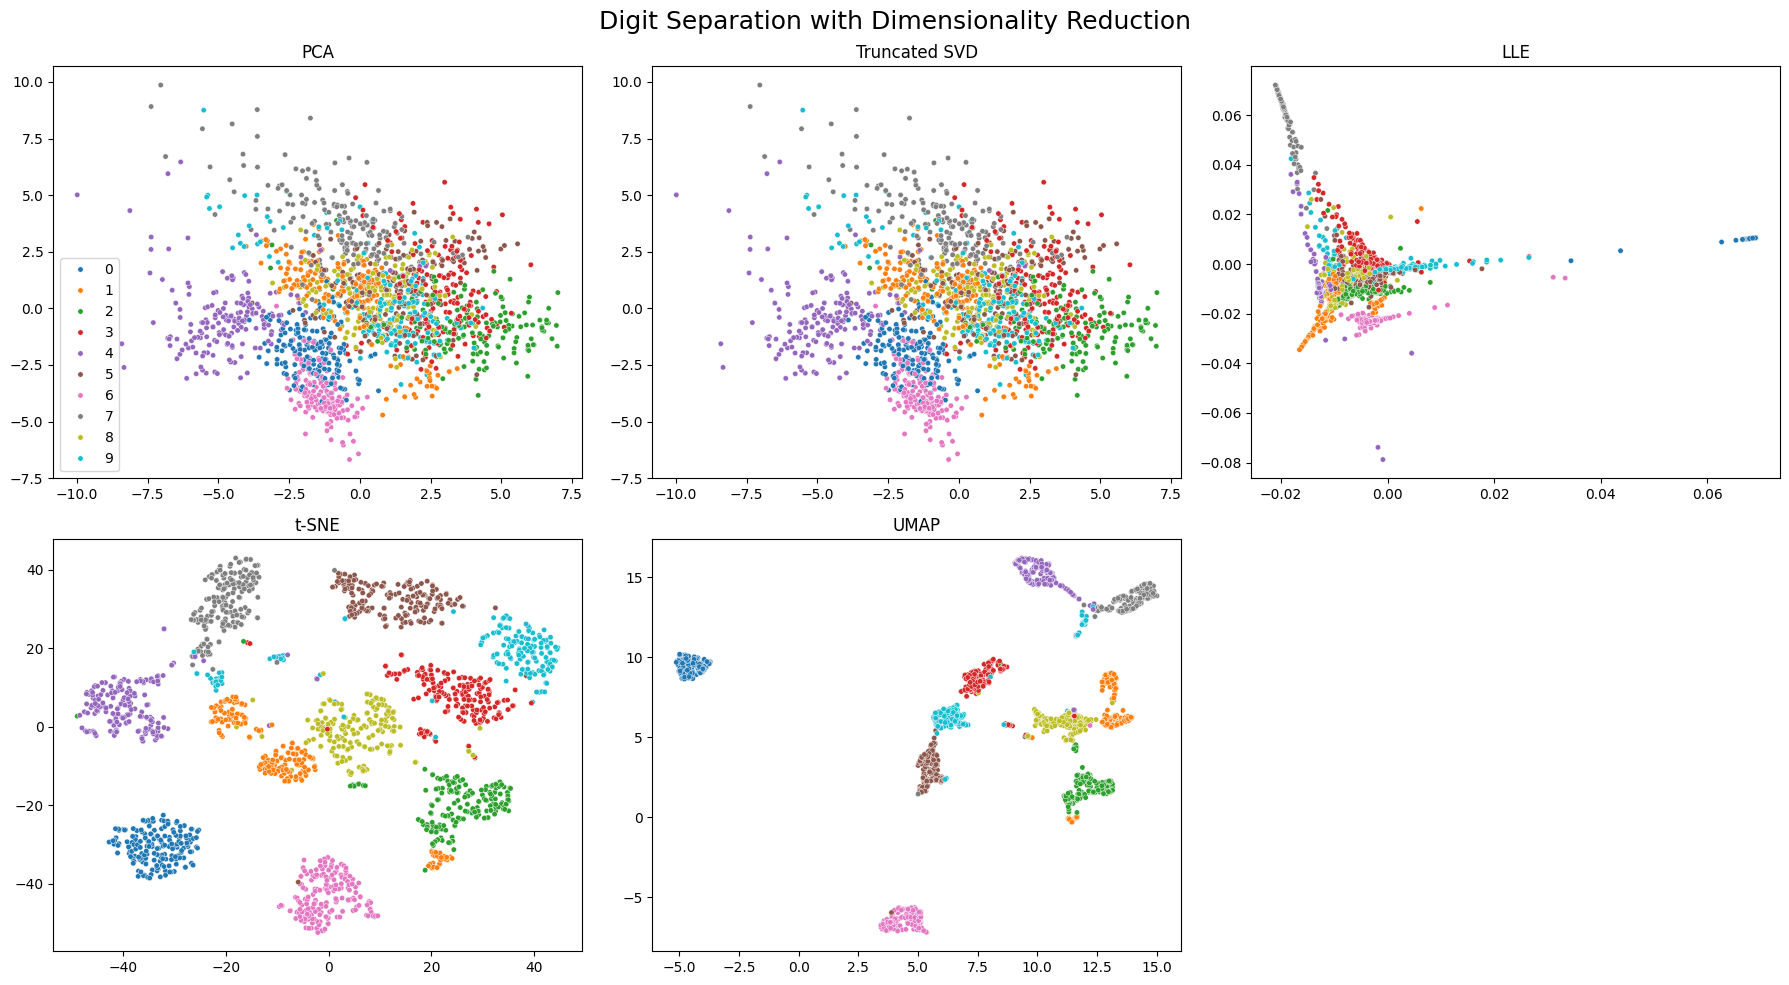

In [216]:
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, (name, reducer) in enumerate(reducers.items()):
    X_reduced = reducer.fit_transform(X_scaled)
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1],
        hue=y, palette="tab10", s=15, ax=axs[i], legend=(i == 0)
    )
    axs[i].set_title(name)

axs[-1].axis('off')


plt.suptitle("Digit Separation with Dimensionality Reduction", fontsize=18)
plt.tight_layout()
plt.show()

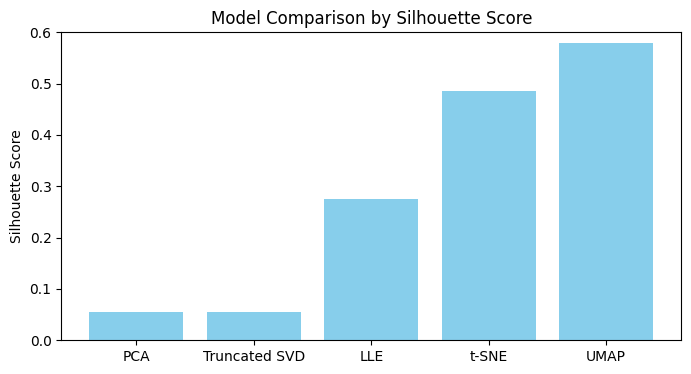

In [202]:
from sklearn.metrics import silhouette_score

scores = {}

for name, reducer in reducers.items():
    X_reduced = reducer.fit_transform(X_scaled)
    score = silhouette_score(X_reduced, y)
    scores[name] = score
    # print(f"{name} Silhouette Score: {score:.3f}")

plt.figure(figsize=(8, 4))
plt.bar(scores.keys(), scores.values(), color='skyblue')
plt.ylabel("Silhouette Score")
plt.title("Model Comparison by Silhouette Score")
plt.ylim(0, 0.6)
plt.show()

### Image Compression using SVD

In [290]:
from skimage import data, color
from skimage.transform import resize

images = [
    # data.astronaut(),
    color.rgb2gray(data.astronaut()),
    data.camera(),
    data.coins()
]

images = [resize(img, (128, 128)) for img in images]

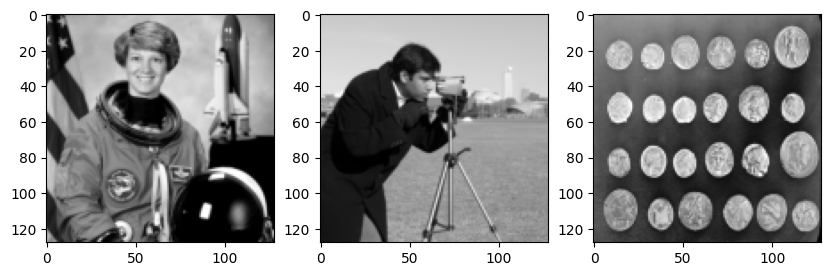

In [291]:
plt.subplots(1, 3, figsize=(10, 5))
for i, img in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap="gray")

In [283]:
def compute_svd(image):
    U, S, VT = np.linalg.svd(image, full_matrices=False)
    return U, S, VT

In [284]:
def reconstruct_image(U, S, VT, rank):
    # Keep only the first `rank` singular values
    S_r = np.diag(S[:rank])
    U_r = U[:, :rank]
    VT_r = VT[:rank, :]
    return U_r @ S_r @ VT_r

The function `reconstruct_image` creates a low-rank approximation of the original image by keeping only the first `rank` singular values and corresponding singular vectors.

- It selects the first `rank` singular values from `S` and forms a diagonal matrix `S_r`.
- It takes the first `rank` columns of `U` (`U_r`) and the first `rank` rows of `VT` (`VT_r`).
- Multiplying these truncated matrices (`U_r @ S_r @ VT_r`) reconstructs an approximation of the original image that captures the most important features while ignoring smaller details.

The `rank` parameter controls how many components (or modes) are used, effectively determining the reduced dimensionality of the reconstructed image. Higher ranks produce more detailed images, while lower ranks yield more compressed, simplified versions.

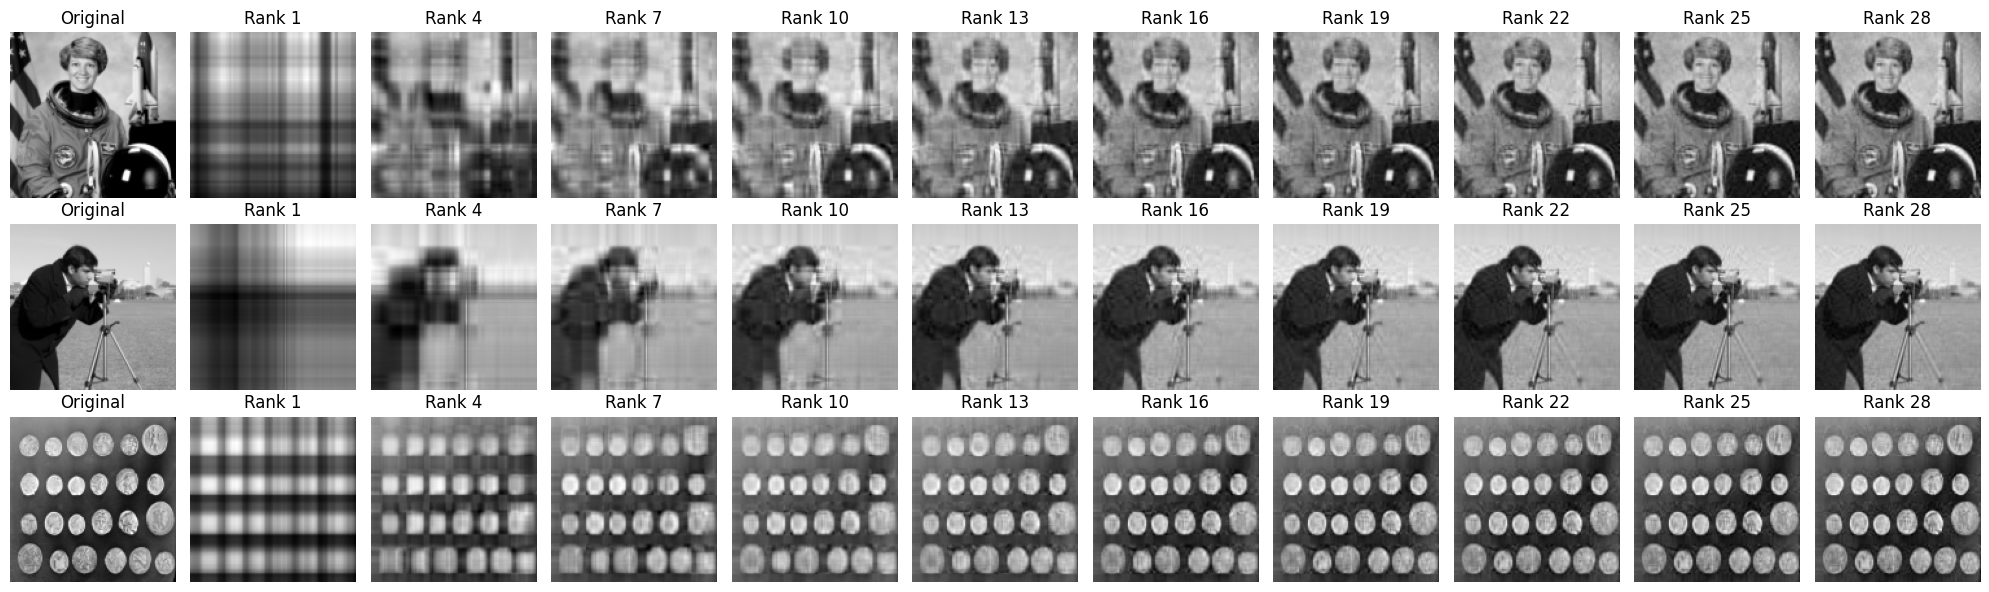

In [285]:
ranks = range(1, 31, 3)
fig, axs = plt.subplots(len(images), len(ranks) + 1, figsize=(20, 6))

for i, img in enumerate(images):
    U, S, VT = compute_svd(img)

    # Plot original image
    axs[i, 0].imshow(img, cmap='gray')
    axs[i, 0].set_title("Original")
    axs[i, 0].axis('off')

    for j, k in enumerate(ranks):
        img_recon = reconstruct_image(U, S, VT, k)
        axs[i, j+1].imshow(img_recon, cmap='gray')
        axs[i, j+1].set_title(f"Rank {k}")
        axs[i, j+1].axis('off')

plt.tight_layout()
plt.show()

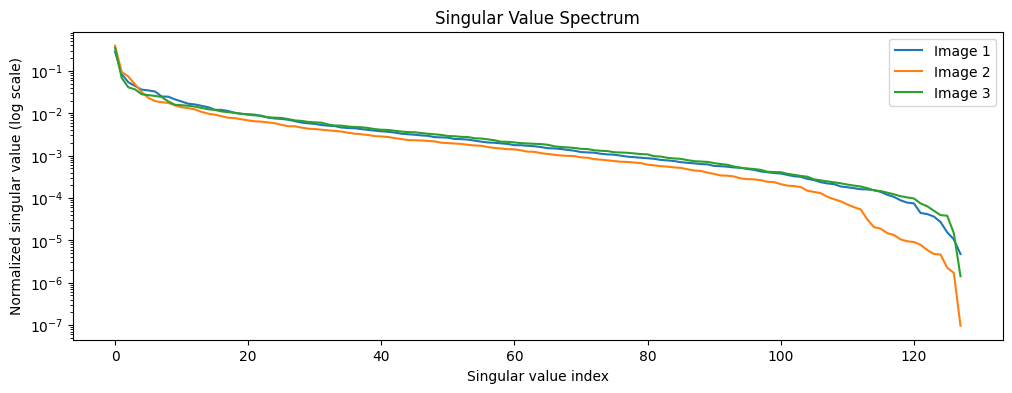

In [286]:
plt.figure(figsize=(12, 4))
for i, img in enumerate(images):
    _, S, _ = compute_svd(img)
    plt.plot(S / S.sum(), label=f'Image {i+1}')
plt.yscale('log')
plt.xlabel("Singular value index")
plt.ylabel("Normalized singular value (log scale)")
plt.title("Singular Value Spectrum")
plt.legend()
plt.show()

This plot shows the **normalized singular value spectrum** for each image on a **logarithmic scale**.

- Each singular value represents how much **information (or “energy”)** a component (mode) carries.
- By **normalizing** (dividing by the total sum), we can interpret them as **relative importance** — how much each component contributes to the entire image.
- The **sharp drop** at the beginning means that the **first few components capture most of the meaningful structure** in the image.
- The remaining singular values are very small and add only **minor details**.
- The **log scale** helps visualize both large and small values, making it easier to see how quickly the importance drops off.

It explains why we can **compress images using only a few components** and still preserve most of their visual quality — the top singular values contain the majority of useful information.

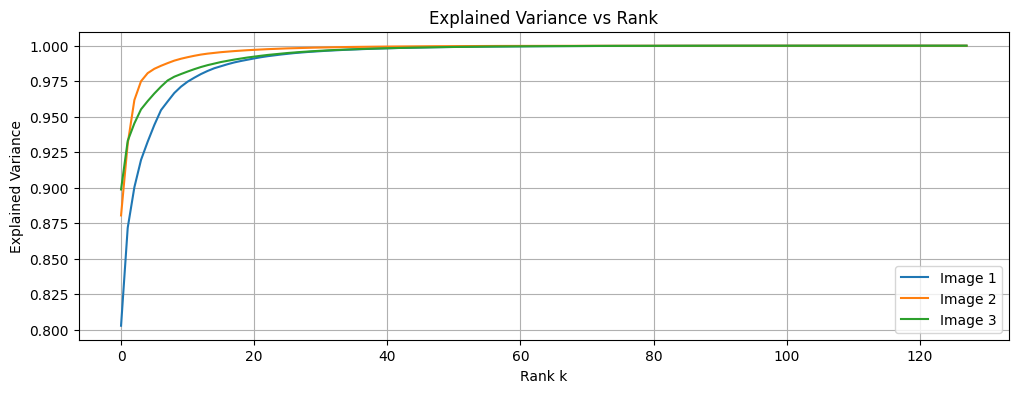

In [292]:
def explained_variance(S, k):
    return np.sum(S[:k]**2) / np.sum(S**2)

plt.figure(figsize=(12, 4))
for i, img in enumerate(images):
    _, S, _ = compute_svd(img)
    ev = [explained_variance(S, k) for k in range(1, len(S)+1)]
    plt.plot(ev, label=f'Image {i+1}')
plt.xlabel("Rank k")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs Rank")
plt.legend()
plt.grid()
plt.show()

This plot illustrates how much of the total variance (information) in each image is captured by the first *k* singular values (components).

- **Explained variance** refers to the proportion of the total “energy” (sum of squared singular values) accounted for by the top *k* components.
- For each rank *k*, the plot displays the cumulative fraction of variance explained by the first *k* singular values.
- The curve typically rises sharply at the beginning, indicating that the initial components explain the majority of the image’s variance.
- As *k* increases, the curve approaches 1, showing that nearly all information is captured.
- This visualization helps to determine the number of components required to reconstruct the image effectively while reducing dimensionality.

In practical terms, a rank *k* can be selected where the explained variance reaches a high threshold (e.g., 90–95%), achieving good compression with minimal loss of information.